In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
train = reduce_mem_usage(pd.read_csv('input/train.csv.zip'))
test = reduce_mem_usage(pd.read_csv('input/test.csv.zip'))
mulliken = reduce_mem_usage(pd.read_csv('input/mulliken_charges.csv.zip'))
dipole = reduce_mem_usage(pd.read_csv('input/dipole_moments.csv.zip'))
structure = reduce_mem_usage(pd.read_csv('input/structures.csv.zip'))
potential = reduce_mem_usage(pd.read_csv('input/potential_energy.csv.zip'))
magnetic = reduce_mem_usage(pd.read_csv('input/magnetic_shielding_tensors.csv.zip'))
scaler = reduce_mem_usage(pd.read_csv('input/scalar_coupling_contributions.csv.zip'))
sub = reduce_mem_usage(pd.read_csv('input/sample_submission.csv.zip'))


Mem. usage decreased to 106.62 Mb (50.0% reduction)
Mem. usage decreased to 52.57 Mb (45.0% reduction)
Mem. usage decreased to 16.09 Mb (54.2% reduction)
Mem. usage decreased to  1.13 Mb (56.2% reduction)
Mem. usage decreased to 51.74 Mb (52.1% reduction)
Mem. usage decreased to  0.81 Mb (37.5% reduction)
Mem. usage decreased to 39.49 Mb (69.3% reduction)
Mem. usage decreased to 115.50 Mb (59.4% reduction)
Mem. usage decreased to 11.95 Mb (68.7% reduction)


In [4]:
train.head(10)

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   
5   5  dsgdb9nsd_000001             2             3  2JHH   
6   6  dsgdb9nsd_000001             2             4  2JHH   
7   7  dsgdb9nsd_000001             3             0  1JHC   
8   8  dsgdb9nsd_000001             3             4  2JHH   
9   9  dsgdb9nsd_000001             4             0  1JHC   

   scalar_coupling_constant  
0                84.8125000  
1               -11.2578125  
2               -11.2578125  
3               -11.2578125  
4                84.8125000  
5               -11.2578125  
6               -11.2578125  
7                84.8125000  
8               -11.2578125  
9                84.8125000

In [5]:
structure.head(10)

molecule_name  atom_index atom                  x                  y  \
0  dsgdb9nsd_000001           0    C -0.012695312500000  1.085937500000000   
1  dsgdb9nsd_000001           1    H  0.002149581909180 -0.006031036376953   
2  dsgdb9nsd_000001           2    H  1.011718750000000  1.463867187500000   
3  dsgdb9nsd_000001           3    H -0.541015625000000  1.447265625000000   
4  dsgdb9nsd_000001           4    H -0.523925781250000  1.437500000000000   
5  dsgdb9nsd_000002           0    N -0.040435791015625  1.024414062500000   
6  dsgdb9nsd_000002           1    H  0.017257690429688  0.012542724609375   
7  dsgdb9nsd_000002           2    H  0.916015625000000  1.358398437500000   
8  dsgdb9nsd_000002           3    H -0.520507812500000  1.343750000000000   
9  dsgdb9nsd_000003           0    O -0.034362792968750  0.977539062500000   

                   z  
0  0.008003234863281  
1  0.001976013183594  
2  0.000276565551758  
3 -0.876464843750000  
4  0.906250000000000  
5  0.062561035156250  
6 -0.027374267578125  
7 -0.028762817382812  
8 -0.775390625000000  
9  0.007602691650391

In [6]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structure, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [7]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

In [8]:
train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)


In [9]:
train['dist_0'] = np.linalg.norm(train_p_0 + train_p_1, axis=1)
test['dist_0'] = np.linalg.norm(test_p_0 + test_p_1, axis=1)

train['dist_1'] = np.max(train_p_0 * train_p_1, axis=1)
test['dist_1'] = np.max(test_p_0 * test_p_1, axis=1)

train['dist_2'] = np.min(train_p_0 * train_p_1, axis=1)
test['dist_2'] = np.min(test_p_0 * test_p_1, axis=1)

train['dist_3'] = np.var(train_p_0 * train_p_1, axis=1)
test['dist_3'] = np.var(test_p_0 * test_p_1, axis=1)

In [10]:
train['c_0'] = train.groupby('molecule_name')['id'].transform('count')
test['c_0'] = test.groupby('molecule_name')['id'].transform('count')

train['c_1'] = train.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
test['c_1'] = test.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')

train['c_2'] = train.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
test['c_2'] = test.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')

train['c_3'] = train['c_2'] / train['c_1']
test['c_3'] = test['c_2'] / test['c_1']

train['m_0'] = train.groupby(['molecule_name', 'atom_index_0'])['dist_2'].transform('max')
test['m_0'] = train.groupby(['molecule_name', 'atom_index_0'])['dist_2'].transform('max')

train['d_0'] = np.max(np.abs(train_p_0 - train_p_1), axis=1)
test['d_0'] = np.max(np.abs(test_p_0 - test_p_1), axis=1)


In [11]:
train['ct_0'] = train.groupby(['molecule_name', 'atom_index_1', 'type'])['id'].transform('count')
test['ct_0'] = test.groupby(['molecule_name', 'atom_index_1', 'type'])['id'].transform('count')

train['ct_1'] = train.groupby(['molecule_name', 'atom_index_0', 'type'])['id'].transform('count')
test['ct_1'] = test.groupby(['molecule_name', 'atom_index_0', 'type'])['id'].transform('count')

train['ct_2'] = train.groupby(['molecule_name', 'type'])['id'].transform('count')
test['ct_2'] = test.groupby(['molecule_name', 'type'])['id'].transform('count')


In [12]:
train = train.merge(potential, on=['molecule_name'], how='left')
test = test.merge(potential, on=['molecule_name'], how='left')

In [13]:
# atom_index_tr = pd.read_csv('input/train.csv.zip', usecols=['atom_index'])
# atom_index_te = pd.read_csv('input/test.csv.zip', usecols=['atom_index'])

In [14]:
mulliken.head()

molecule_name  atom_index  mulliken_charge
0  dsgdb9nsd_000001           0 -0.5356445312500
1  dsgdb9nsd_000001           1  0.1339111328125
2  dsgdb9nsd_000001           2  0.1339111328125
3  dsgdb9nsd_000001           3  0.1339111328125
4  dsgdb9nsd_000001           4  0.1339111328125

In [15]:
from tqdm import tqdm_notebook as tqdm
atomic_radius = {'H':0.38, 'C':0.77, 'N':0.75, 'O':0.73, 'F':0.71} # Without fudge factor

fudge_factor = 0.05
atomic_radius = {k:v + fudge_factor for k,v in atomic_radius.items()}
print(atomic_radius)

electronegativity = {'H':2.2, 'C':2.55, 'N':3.04, 'O':3.44, 'F':3.98}

#structures = pd.read_csv(structures, dtype={'atom_index':np.int8})

atoms = structure['atom'].values
atoms_en = [electronegativity[x] for x in tqdm(atoms)]
atoms_rad = [atomic_radius[x] for x in tqdm(atoms)]

structure['EN'] = atoms_en
structure['rad'] = atoms_rad

display(structure.head())

{'H': 0.43, 'C': 0.8200000000000001, 'N': 0.8, 'O': 0.78, 'F': 0.76}


molecule_name  atom_index atom                 x                  y  \
0  dsgdb9nsd_000001           0    C -0.01269531250000  1.085937500000000   
1  dsgdb9nsd_000001           1    H  0.00214958190918 -0.006031036376953   
2  dsgdb9nsd_000001           2    H  1.01171875000000  1.463867187500000   
3  dsgdb9nsd_000001           3    H -0.54101562500000  1.447265625000000   
4  dsgdb9nsd_000001           4    H -0.52392578125000  1.437500000000000   

                   z    EN   rad  
0  0.008003234863281  2.55  0.82  
1  0.001976013183594  2.20  0.43  
2  0.000276565551758  2.20  0.43  
3 -0.876464843750000  2.20  0.43  
4  0.906250000000000  2.20  0.43

In [16]:
train = train.merge(structure.groupby(['molecule_name'])['EN'].agg(['mean']), on=['molecule_name'], how='left')
test = test.merge(structure.groupby(['molecule_name'])['EN'].agg(['mean']), on=['molecule_name'], how='left')

train = train.merge(structure.groupby(['molecule_name'])['rad'].agg(['mean']), on=['molecule_name'], how='left')
test = test.merge(structure.groupby(['molecule_name'])['rad'].agg(['mean']), on=['molecule_name'], how='left')

In [17]:
train = train.merge(structure.groupby(['molecule_name'])['rad'].agg(['var']), on=['molecule_name'], how='left')
test = test.merge(structure.groupby(['molecule_name'])['rad'].agg(['var']), on=['molecule_name'], how='left')

In [18]:
magnetic.head()

molecule_name  atom_index          XX            YX                 ZX  \
0  dsgdb9nsd_000001           0  195.375000  0.0000000000 -0.000100016593933   
1  dsgdb9nsd_000001           1   31.343750 -1.2314453125  4.054687500000000   
2  dsgdb9nsd_000001           2   31.578125  1.2177734375 -4.148437500000000   
3  dsgdb9nsd_000001           3   31.515625  4.1093750000  1.272460937500000   
4  dsgdb9nsd_000001           4   31.406250 -4.0937500000 -1.179687500000000   

             XY          YY                 ZY                 XZ  \
0  0.0000000000  195.375000  0.000699996948242 -0.000100016593933   
1 -1.2314453125   28.953125 -1.717773437500000  4.054687500000000   
2  1.2177734375   28.906250 -1.603515625000000 -4.148437500000000   
3  4.1093750000   33.906250  1.695312500000000  1.272460937500000   
4 -4.0937500000   34.062500  1.625976562500000 -1.179687500000000   

                  YZ          ZZ  
0  0.000699996948242  195.375000  
1 -1.717773437500000   34.093750  
2 -1.603515625000000   33.906250  
3  1.695312500000000   28.953125  
4  1.625976562500000   28.906250

In [19]:
train.head()

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   

   scalar_coupling_constant atom_0               x_0                y_0  \
0                84.8125000      H  0.00214958190918 -0.006031036376953   
1               -11.2578125      H  0.00214958190918 -0.006031036376953   
2               -11.2578125      H  0.00214958190918 -0.006031036376953   
3               -11.2578125      H  0.00214958190918 -0.006031036376953   
4                84.8125000      H  1.01171875000000  1.463867187500000   

                 z_0   ...                   c_3                m_0  \
0  0.001976013183594   ...     1.000000000000000 -0.006549835205078   
1  0.001976013183594   ...     0.250000000000000 -0.006549835205078   
2  0.001976013183594   ...     0.500000000000000 -0.006549835205078   
3  0.001976013183594   ...     0.750000000000000 -0.006549835205078   
4  0.000276565551758   ...     1.333333333333333 -0.012847900390625   

            d_0  ct_0  ct_1  ct_2  potential_energy  mean_x  mean_y      var  
0  1.0917968750     4     1     4         -40.53125    2.27   0.508  0.03042  
1  1.4697265625     1     3     6         -40.53125    2.27   0.508  0.03042  
2  1.4531250000     2     3     6         -40.53125    2.27   0.508  0.03042  
3  1.4433593750     3     3     6         -40.53125    2.27   0.508  0.03042  
4  1.0244140625     4     1     4         -40.53125    2.27   0.508  0.03042  

[5 rows x 32 columns]

In [20]:
x_magnetic = magnetic.atom_index
x_index = magnetic.molecule_name

magnetic['atom_index_0'] = x_magnetic


In [21]:
magnetic.head()

molecule_name  atom_index          XX            YX                 ZX  \
0  dsgdb9nsd_000001           0  195.375000  0.0000000000 -0.000100016593933   
1  dsgdb9nsd_000001           1   31.343750 -1.2314453125  4.054687500000000   
2  dsgdb9nsd_000001           2   31.578125  1.2177734375 -4.148437500000000   
3  dsgdb9nsd_000001           3   31.515625  4.1093750000  1.272460937500000   
4  dsgdb9nsd_000001           4   31.406250 -4.0937500000 -1.179687500000000   

             XY          YY                 ZY                 XZ  \
0  0.0000000000  195.375000  0.000699996948242 -0.000100016593933   
1 -1.2314453125   28.953125 -1.717773437500000  4.054687500000000   
2  1.2177734375   28.906250 -1.603515625000000 -4.148437500000000   
3  4.1093750000   33.906250  1.695312500000000  1.272460937500000   
4 -4.0937500000   34.062500  1.625976562500000 -1.179687500000000   

                  YZ          ZZ  atom_index_0  
0  0.000699996948242  195.375000             0  
1 -1.717773437500000   34.093750             1  
2 -1.603515625000000   33.906250             2  
3  1.695312500000000   28.953125             3  
4  1.625976562500000   28.906250             4

In [22]:
train = train.merge(magnetic, on=['molecule_name', 'atom_index_0'], how='left')
test = test.merge(magnetic, on=['molecule_name', 'atom_index_0'], how='left')

magnetic['atom_index_1'] = x_magnetic

train = train.merge(magnetic, on=['molecule_name', 'atom_index_1'], how='left')
test = test.merge(magnetic, on=['molecule_name', 'atom_index_1'], how='left')


In [24]:
x_mulliken = mulliken.atom_index
x_index = magnetic.molecule_name

mulliken['atom_index_0'] = x_mulliken


In [28]:
train['atom_index_0'] = train['atom_index_0_x'] 
test['atom_index_0'] = test['atom_index_0_x'] 

In [29]:
train = train.merge(mulliken, on=['molecule_name', 'atom_index_0'], how='left')
test = test.merge(mulliken, on=['molecule_name', 'atom_index_0'], how='left')

mulliken['atom_index_1'] = x_mulliken

train = train.merge(mulliken, on=['molecule_name', 'atom_index_1'], how='left')
test = test.merge(mulliken, on=['molecule_name', 'atom_index_1'], how='left')


In [40]:
train['claw'] = train.mulliken_charge_x * train.mulliken_charge_y / train['dist'] ** 2
test['claw'] = test.mulliken_charge_x * test.mulliken_charge_y / test['dist'] ** 2

In [41]:
y = train['scalar_coupling_constant']

In [42]:
np.unique(train['type'])

array(['1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'],
      dtype=object)

In [43]:
def metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(metrics.mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)
#df for evaluate
eval_df = pd.DataFrame({"type": train["type"]})
eval_df["scalar_coupling_constant"] = y

In [44]:
train.head()

id     molecule_name  atom_index_0_x  atom_index_1  type  \
0   0  dsgdb9nsd_000001               1             0  1JHC   
1   1  dsgdb9nsd_000001               1             2  2JHH   
2   2  dsgdb9nsd_000001               1             3  2JHH   
3   3  dsgdb9nsd_000001               1             4  2JHH   
4   4  dsgdb9nsd_000001               2             0  1JHC   

   scalar_coupling_constant atom_0               x_0                y_0  \
0                84.8125000      H  0.00214958190918 -0.006031036376953   
1               -11.2578125      H  0.00214958190918 -0.006031036376953   
2               -11.2578125      H  0.00214958190918 -0.006031036376953   
3               -11.2578125      H  0.00214958190918 -0.006031036376953   
4                84.8125000      H  1.01171875000000  1.463867187500000   

                 z_0        ...                       YZ_y        ZZ_y  \
0  0.001976013183594        ...          0.000699996948242  195.375000   
1  0.001976013183594        ...         -1.603515625000000   33.906250   
2  0.001976013183594        ...          1.695312500000000   28.953125   
3  0.001976013183594        ...          1.625976562500000   28.906250   
4  0.000276565551758        ...          0.000699996948242  195.375000   

   atom_index_0_y  atom_index_0_x  atom_index_x  mulliken_charge_x  \
0               0               1             1    0.1339111328125   
1               2               1             1    0.1339111328125   
2               3               1             1    0.1339111328125   
3               4               1             1    0.1339111328125   
4               0               2             2    0.1339111328125   

   atom_index_y  mulliken_charge_y  atom_index_0_y               claw  
0             0   -0.5356445312500               0 -0.060150146484375  
1             2    0.1339111328125               2  0.005638122558594  
2             3    0.1339111328125               3  0.005645751953125  
3             4    0.1339111328125               4  0.005638122558594  
4             0   -0.5356445312500               0 -0.060150146484375  

[5 rows x 60 columns]

In [67]:
atom_index_tr = pd.read_csv('input/train.csv.zip', usecols=['atom_index_0', 'atom_index_1'])
atom_index_te = pd.read_csv('input/test.csv.zip', usecols=['atom_index_0', 'atom_index_1'])

In [68]:
train['atom_index_0'] = atom_index_tr.atom_index_0
test['atom_index_0'] = atom_index_te.atom_index_0

train['atom_index_1'] = atom_index_tr.atom_index_1
test['atom_index_1'] = atom_index_tr.atom_index_1

In [69]:
train = train.merge(scaler, on=['molecule_name', 'atom_index_0', 'atom_index_1', 'type'], how='left')
test = test.merge(scaler, on=['molecule_name', 'atom_index_0', 'atom_index_1', 'type'], how='left')


In [ ]:
train.head()

In [71]:
train.shape

(4658147, 65)

In [72]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 10,
          'learning_rate': 0.25,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

In [73]:
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
n_split = 5
kf = KFold(n_splits=n_split, random_state=666, shuffle=True)
    
for type_ in np.unique(train['type']):

    
    train_ = train[train['type'] == type_]
    test_ = test[test['type'] == type_]
    
    train_index = train_.index
    test_index = test_.index
    
    y_ = y[train['type'] == type_]
    
    features = [c for c in train_.columns if c not in ['id', 'molecule_name', 'x_0', 'y_0', 'z_0',
                                                       'x_1', 'y_1', 'z_1', 'atom_index', 'atom_index_0_y',
                                                       'atom_index_1_y', 'type', 'scalar_coupling_constant',
                                                       'atom_0', 'atom_1']]

    for i, (train_idx, valid_idx) in enumerate(kf.split(train_)):  
        print(f'Fold {i + 1}')
        x_train = train_[features]
        y_train = y_
        trn_data = lgb.Dataset(x_train.iloc[train_idx], label=y_train.iloc[train_idx])
        val_data = lgb.Dataset(x_train.iloc[valid_idx], label=y_train.iloc[valid_idx])

        num_round = 1000
        clf = lgb.train(params, trn_data, num_round, valid_sets=[trn_data, val_data],
                        verbose_eval=500, early_stopping_rounds=100)
        oof[train_index[valid_idx]] = clf.predict(x_train.iloc[valid_idx], num_iteration=clf.best_iteration)

        predictions[test_index] += clf.predict(test_[features], num_iteration=clf.best_iteration) / n_split

    
print("CV score: {:<8.5f}".format(metric(eval_df, oof)))

KeyboardInterrupt: 

In [50]:
predictions

array([ 31.88498494, 172.26153317,   5.26238681, ...,   1.3613562 ,
         9.7470092 , 119.06837258])

In [51]:
test.shape

(2505542, 59)

In [52]:
sub = pd.read_csv('input/sample_submission.csv.zip')

id  scalar_coupling_constant
0  4658147                         0
1  4658148                         0
2  4658149                         0
3  4658150                         0
4  4658151                         0

In [73]:
sub.shape

(2505542, 2)

In [ ]:
len(predictions)

In [54]:
sub['scalar_coupling_constant'] = predictions

sub.to_csv("submission-lgbm-v0.2.0.csv", index=False)

In [55]:
sub.head()

id  scalar_coupling_constant
0  4658147        31.884984938804639
1  4658148       172.261533171232657
2  4658149         5.262386812740331
3  4658150       170.199211570850878
4  4658151        30.630240760045808

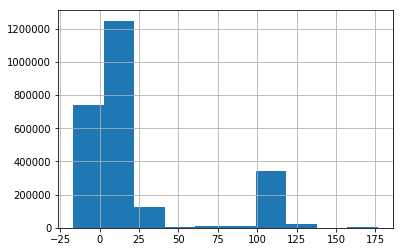

In [56]:
sub['scalar_coupling_constant'].hist()

In [57]:
pd.DataFrame(oof).to_csv('oofs/validation_lgbm_v0.2.0.csv', index=False)
pd.DataFrame(predictions).to_csv('oofs/test_lgbm_v0.2.0.csv', index=False)

In [58]:
np.log(0.1)

-2.3025850929940455

In [62]:
np.e**(-2)

0.1353352832366127

In [60]:
np.e**(1)

2.718281828459045

In [61]:
mulliken.head()

molecule_name  atom_index  mulliken_charge  atom_index_0  atom_index_1
0  dsgdb9nsd_000001           0 -0.5356445312500             0             0
1  dsgdb9nsd_000001           1  0.1339111328125             1             1
2  dsgdb9nsd_000001           2  0.1339111328125             2             2
3  dsgdb9nsd_000001           3  0.1339111328125             3             3
4  dsgdb9nsd_000001           4  0.1339111328125             4             4